# 1. Simulating an exponential integrate-and-fire neuron

The exponential integrate-and-fire (EIF) model represents the membrane potential by:
$\tau_m \frac{dV}{dt} = -(V - V_{\text{rest}}) + \Delta_T \exp\!\left(\frac{V - V_T}{\Delta_T}\right) + R I_0 \quad (1)$


In [16]:
# constants
V_rest = -70 # mV
V_thresh = 0 # mV
R = 1 # G Ohms
V_T = -50 # mV
sharp = 2 # mV
tau_m = 10 # ms
dt = 0.01 # ms

## a)
We will plot the right hand side of (1) over the range $-80 \leq V \leq -40$.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Change in Membrane Potential for EIF Neuron')

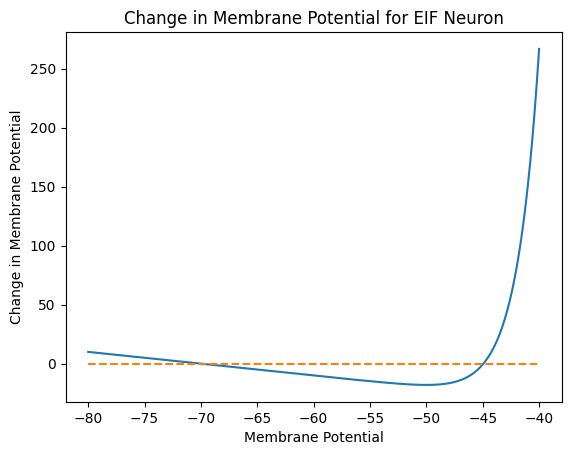

In [18]:
precision= 200
xs = np.linspace(-80,-40, precision)

def EIF_RHS(V, V_rest, sharp, V_T, I_0=0):
  return -(V - V_rest) + sharp * np.exp((V-V_T)/sharp) + I_0

ys = EIF_RHS(xs, V_rest, sharp, V_T)
plt.plot(xs, ys)

# plot a line at y = 0
y_0 = np.zeros(precision)
plt.plot(xs, y_0, '--')

plt.xlabel("Membrane Potential")
plt.ylabel("Change in Membrane Potential")
plt.title("Change in Membrane Potential for EIF Neuron")

$f(V) = 0$ around the values of $V = -70$ and $V = -45$. At $V=-70$, the membrane is at its resting potential so it is stable at that voltage. At $V=-45$ the neuron is passed the $V_T$ value so the input to the exponential function is positive and growing so the neuron's membrane potential is spiking.

## b)


In [31]:
voltages = np.arange(-50,-40,2)
T = np.arange(0,50,dt) # ms

membrane_evolutions = []

for i in range(voltages.size):
    V_init = voltages[i]
    membrane_potential = [V_init]
    for j in range(1,T.size):
        new_membrane_potential = membrane_potential[j-1] + dt*EIF_RHS(membrane_potential[j-1], V_rest, sharp, V_T) / tau_m
        if new_membrane_potential >= V_thresh:
            membrane_potential.append(V_thresh)
        else:
            membrane_potential.append(new_membrane_potential)
    membrane_evolutions.append(membrane_potential)

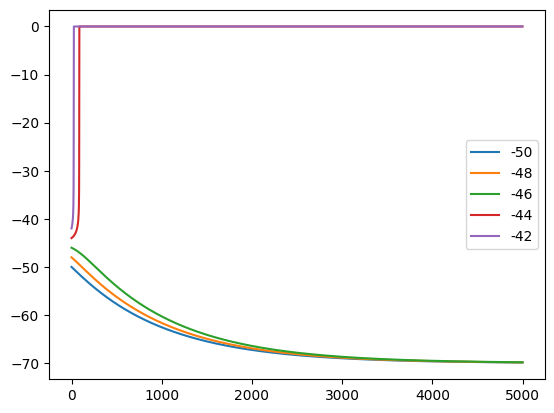

In [32]:
# plot the evolution of the membrane potential for different initial voltages
for i in range(len(membrane_evolutions)):
    plt.plot(membrane_evolutions[i], label=f"{voltages[i]}")
plt.legend()

An initial voltage of greater than $-44$ mV leads V to cross the threshold. This makes sense when we consider the first graph that shows that any membrane voltage above -45V will enter into a positive feedback loop and spike.

## c)
Investigating external current.

In [33]:
current_values = np.arange(18,22,1)
T_100ms = np.arange(0,100,dt)

potentials = []

for i in range(current_values.size):
    I_0 = current_values[i]
    membrane_potential = [V_rest]
    flag = False
    for j in range(1,T_100ms.size):
        new_membrane_potential = membrane_potential[j-1] + dt*EIF_RHS(membrane_potential[j-1], V_rest, sharp, V_T, I_0)/tau_m
        if new_membrane_potential > V_thresh and not flag:
            membrane_potential.append(V_thresh)
            flag = True
        elif flag:
            membrane_potential.append(V_rest)
            flag = False
        else:
            membrane_potential.append(new_membrane_potential)
    potentials.append(membrane_potential)

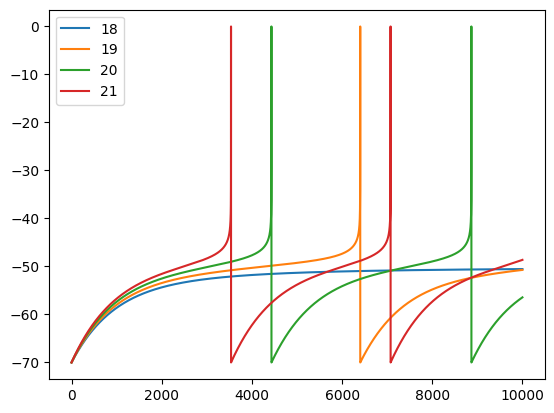

In [34]:
# plot the evolution of the membrane potential for different initial voltages
for i in range(len(potentials)):
    plt.plot(potentials[i], label=f"{current_values[i]}")
plt.legend()

It appears that we need more than 18 pA to generate a spike, and we see a spike at 19 pA.

# 2. Simulating adaptive EIF neurons of different firing patterns
The adaptive exponential integrate-and-fire model consists of an exponential nonlinearity in the voltage equation and a single adaptation variable $w$.

$\tau_m \frac{dV}{dt} = -(V - V_{\text{rest}}) + \Delta_T \exp\!\left(\frac{V - V_T}{\Delta_T}\right) - R w + R I_0 \quad \quad (2)$

$\tau_m \frac{dw}{dt} = a(V - V_{\text{rest}}) - w + b \tau_m \sum_{k} \delta (t-t_k) \quad \quad(3)$

In [23]:
# constants and initial conditions

V_thresh = 0 # mV
V_rest = -70 # mV
w_init = 0
dt = 0.01
R = 0.5 #G Ohm
V_T = -50 # mV
sharp = 2 # mV
I_0 = 56 # pA

T_300ms = np.arange(0,300,dt)


# params for different types of firing
# [tau_m, a, tau_w, b, V_reset]

tonic = [20, 0, 30, 60, -55]
adapting = [20, 0, 100, 5, -55]
initial_bursting = [5, 0.5, 100 , 7, -51]
busting = [5, -0.5, 100, 7, -48]
transient = [10, 1, 100, 10, -60]

In [24]:
# watch the tau_m and tau_w

def adaptive_EIF_dV(V, V_rest, sharp, V_T, R, w, I_0, tau_m):
  return (-(V - V_rest) + sharp * np.exp((V-V_T)/sharp) - R*w + R*I_0) / tau_m

def adaptation_dw_nospike(a, V, V_rest, w, tau_w):
  return (a*(V - V_rest) - w) / tau_w

def run_adaptive_EIF(tau_m, V_rest, sharp, V_T, R, I_0, tau_w, a, b, V_reset, w_init=w_init):
  retV = [V_rest]
  retw = [w_init]
  flag = False
  for j in range(1,T_300ms.size):
      V = retV[j-1] + dt*adaptive_EIF_dV(retV[j-1], V_rest, sharp, V_T, R, retw[j-1], I_0, tau_m)
      if V > V_thresh and not flag:
          retV.append(V_thresh)
          retw.append(retw[j-1] + b)
          flag = True
      elif flag:
          retV.append(V_reset)
          w_change = adaptation_dw_nospike(a, V_rest, V_rest, retw[j-1], tau_w)
          retw.append(retw[j-1] + dt*w_change)
          flag = False
      else:
          retV.append(V)
          w_change = adaptation_dw_nospike(a, V_rest, V_rest, retw[j-1], tau_w)
          retw.append(retw[j-1] + dt*w_change)
  return retV, retw

tonic_v, tonic_w = run_adaptive_EIF(tonic[0], V_rest, sharp, V_T, R, I_0, tonic[2], tonic[1], tonic[3], tonic[4])
adapt_v, adapt_w = run_adaptive_EIF(adapting[0], V_rest, sharp, V_T, R, I_0, adapting[2], adapting[1], adapting[3], adapting[4])
IB_v, IB_w = run_adaptive_EIF(initial_bursting[0], V_rest, sharp, V_T, R, I_0, initial_bursting[2], initial_bursting[1], initial_bursting[3], initial_bursting[4])
busting_v, busting_w = run_adaptive_EIF(busting[0], V_rest, sharp, V_T, R, I_0, busting[2], busting[1], busting[3], busting[4])
transient_v, transient_w = run_adaptive_EIF(transient[0], V_rest, sharp, V_T, R, I_0, transient[2], transient[1], transient[3], transient[4])

In [25]:
def graphType(v, w, t):
    fig, axs = plt.subplots(1,2, figsize=(8,4))

    axs[0].plot(T_300ms, v)
    axs[0].set_ylabel("Membrane Potential V")

    axs[1].plot(T_300ms, w)
    axs[1].set_ylabel("Adaptation w")

    # plt.tight_layout()
    plt.suptitle(t)
    plt.show()

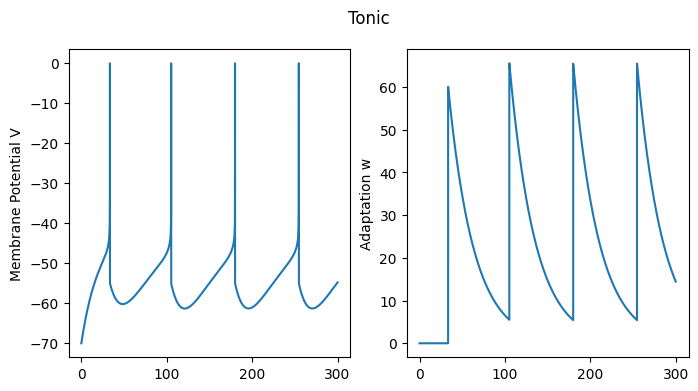

In [26]:
graphType(tonic_v, tonic_w, "Tonic")

The membrane potential increases almost linearly until the moment of spiking, and the adaptation variable decreases almost but not quite down to zero after each spike and before the next.

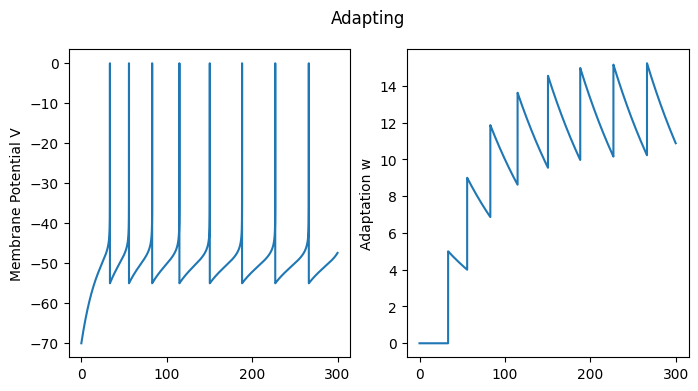

In [27]:
graphType(adapt_v, adapt_w, "Adapting")

The spikes are becoming more spaced out that at the start - the interspike interval appears to be increasing at least initially. The value of $w$ the moment before the spike appears to increase and then level out and approach 10 pA.

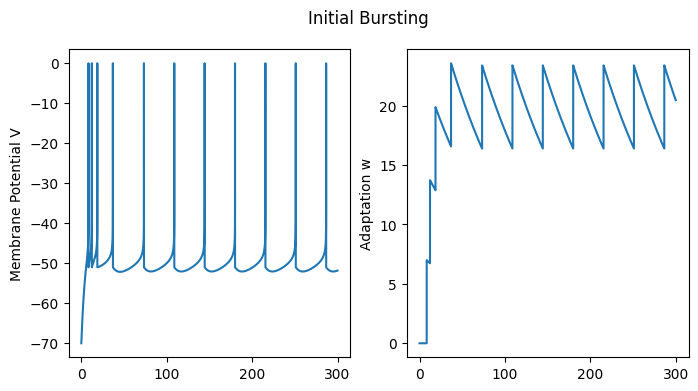

In [28]:
graphType(IB_v, IB_w, "Initial Bursting")

There is a burst of spikes at the start as $w$ climbs up to settle at a value of around 17 the moment before spiking. The pre-spike increase in membrane voltage appears less linear than tonic and adapting and more quadratic or exponential.

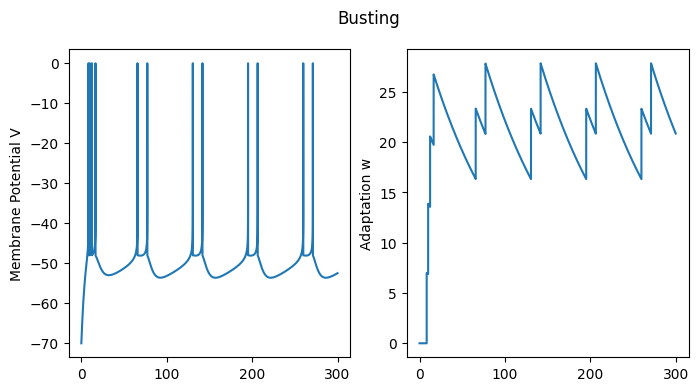

In [29]:
graphType(busting_v, busting_w, "Busting")

There is a burst of spikes at the start as w enters into a region where it has a consistent pattern (between 16 and 30 pA). Then there are patterns of two spikes in a short time.

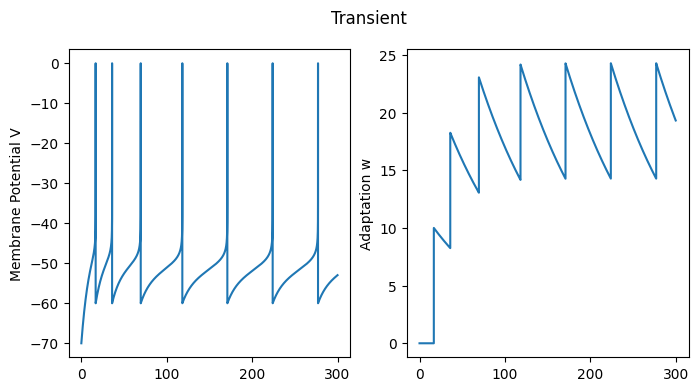

In [30]:
graphType(transient_v, transient_w, "Transient")

This appears similar to adapting but with more of a sigmoid pattern in the pre-spike membrane potential. Pre-spike $w$ appears to settle around 14 pA.